In [1]:
# 导入需要的模块
import tensorflow as tf # tensorflow模块，深度学习框架
import keras # keras模块，深度学习框架
import re # 正则表达式
import numpy as np # numpy数组
import pandas as pd # pandas表格
import matplotlib.pyplot as plt # matplotlib 数据可视化
from PIL import Image # 读取图片
from tqdm import tqdm # 显示循环进度条
from sklearn.model_selection import train_test_split # 训练集、验证集、测试集的划分
from itertools import product # 迭代工具
from tensorflow.keras.models import load_model # 用于加载模型
from sklearn.utils import class_weight # 用于计算样本的权重
from sklearn.metrics import roc_curve, auc # 用于绘画ROC曲线，计算AUC值
from keras.preprocessing.image import ImageDataGenerator # keras模块的图片预处理模块，可用于数据增强
from keras.optimizers import Adam # Adam优化器
from collections import Counter # 词频统计包
import time
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import pandas as pd
train_data = pd.read_csv('train_data.csv',encoding='ISO-8859-1')
test_data = pd.read_csv('test_data.csv',encoding='ISO-8859-1')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,168ac3d396c7d588,if there is a chromosone then e=what is it?Sma...,0,0,0,0,0,0
1,168bc99fa2cfd9aa,Hollywood Undead \n\nI have collected articles...,0,0,0,0,0,0
2,168cd51c24508159,"""\n\n Rollback \n\nI've enabled rollback on yo...",0,0,0,0,0,0
3,168d515e2e99f78d,Another backlog. Thanks. (Trouble?/My Work),0,0,0,0,0,0
4,168d5a1c66f5e8bf,""" - unsigned\n\nWe do include it. This article...",0,0,0,0,0,0


In [4]:
# 处理训练集
# 将对应的标签拿出来
train_labels = np.array(train_data['toxic'], dtype=np.int32)
t0 = time.time()
# 分词处理
train_intro_texts = []
for intro in train_data['comment_text']:
    intro = intro.replace(',',' ').replace('.',' ').replace('\n',' ').replace('?',' ').replace('!',' ').replace(';',' ').replace(':',' ')
    intro = intro.replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ').replace('{',' ').replace('}',' ')
    intro = intro.replace('"',' ').replace('."',' ').replace('?"',' ').replace('!"',' ').replace('-','')
    intro = intro.lower()
    intro = [i for i in intro.split()]
    train_intro_texts.append(intro)
print("分词时间：%s"%(time.time()-t0))

分词时间：4.561324596405029


In [5]:
# 处理测试集
# 将对应的标签拿出来
test_labels = np.array(test_data['toxic'], dtype=np.int32)
t0 = time.time()
# 分词处理
test_intro_texts = []
for intro in test_data['comment_text']:
    intro = intro.replace(',',' ').replace('.',' ').replace('\n',' ').replace('?',' ').replace('!',' ').replace(';',' ').replace(':',' ')
    intro = intro.replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ').replace('{',' ').replace('}',' ')
    intro = intro.replace('"',' ').replace('."',' ').replace('?"',' ').replace('!"',' ').replace('-','')
    intro = intro.lower()
    intro = [i for i in intro.split()]
    test_intro_texts.append(intro)
print("分词时间：%s"%(time.time()-t0))

分词时间：0.21814513206481934


In [6]:
# 训练集，验证集，测试集的划分
# text_s,text_test_s,\
# label_s,label_test_s = train_test_split(
#     intro_texts,labels,
#     test_size=1.0, 
#     stratify=labels,
#     random_state=233)
text_train,text_val,\
label_train,label_val = train_test_split(
    train_intro_texts,train_labels,
    test_size=0.2, 
    stratify=train_labels,
    random_state=233)  # 训练集和验证集的划分
text_test = test_intro_texts
label_test = test_labels
print(text_train[0])
print(label_train[0])
print(len(text_train))
print(len(label_train))

['the', 'wikipedia', 'message', 'at', 'top', 'of', 'page', 'tonight', 'suggested', 'size', 'of', 'page', 'was', 'too', 'long', 'at', '74k', 'so', 'i', 'placed', 'the', 'freemasonry', 'in', 'specific', 'countries', 'on', 'a', 'new', 'seperate', 'page', 'like', 'another', 'user', 'did', 'for', 'the', 'grand', 'lodge', 'listings', 'i', 'also', 'noticed', 'some', "'famous", "freemason'", 'included', 'in', 'the', 'cultural', 'reference', 'paragraph', 'that', 'were', 'already', 'included', 'on', 'the', 'famous', 'freemasons', 'page', 'i', 'moved', 'the', 'famous', 'freemasons', 'link', 'to', 'a', 'higher', 'position', 'in', 'the', 'additional', 'section', 'also', 'we', 'could', 'also', 'do', 'additional', 'pages', 'on', 'what', 'regular', 'freemasonry', 'considers', "'clandestine'", 'freemasonry', 'the', 'golden', 'dawn', 'o', 't', 'o', 'wiccan', 'etc', 'etc', 'there', 'was', 'a', 'brief', 'entry', 'on', 'the', 'g', 'd', 'in', 'the', 'cultural', 'references', 'that', 'could', 'be', 'put', 't

In [18]:
plt.style.use('ggplot') # 使用ggplot风格

def ROC(y_true,y_pre):#用于绘制ROC曲线
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1) #计算真正率和假正率
    roc_auc = auc(fpr,tpr) #计算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc) #绘制ROC曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') #绘制直线y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('ROC curve',fontsize=20)
    plt.legend(loc="lower right")
    plt.show()
def evaluate(model,text_test,label_test):
    predict_test = model.predict(text_test)
    ROC(list(label_test.flatten()),predict_test.flatten())

    y_true = list(label_test.flatten())
    y_pre = predict_test.flatten()
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1)
    data_val_model4 = pd.DataFrame(columns={'val':[]})
    data_val_model4['true']=label_test
    # 阈值的选择: fpr < 0.05
    for i in range(len(fpr)):
        if fpr[i] >= 0.05:
            index = i - 1
            break
    predict_threshold = threshold[index]
    predict_val = predict_test
    predict_class = np.zeros(len(text_test))
    print('开始预测')
    t0 = time.time()
    for i in range(len(text_test)):
        if predict_val[i] > predict_threshold:
            data_val_model4.loc[i,'val'] = 1
        else:
            data_val_model4.loc[i,'val'] = 0
    print("预测结束，耗时：%2s s"%(time.time()-t0))

    cf_matrix = confusion_matrix(data_val_model4['true'],data_val_model4['val'])
    TP = cf_matrix[0][0]#data_val_model4[(data_val_model4.true==1)&(data_val_model4.val==1)].shape[0]
    TN = cf_matrix[1][1]#data_val_model4[(data_val_model4.true==0)&(data_val_model4.val==0)].shape[0]
    FP = cf_matrix[0][1]#data_val_model4[(data_val_model4.true==0)&(data_val_model4.val==1)].shape[0]
    FN = cf_matrix[1][0]#data_val_model4[(data_val_model4.true==1)&(data_val_model4.val==0)].shape[0]
    print(cf_matrix)
    print("Accuracy: %3f"%((TP+TN)/(TP+TN+FP+FN)))
    print("Precision: %3f"%(TP/(TP+FP)))
    print("Recall: %3f"%((TP)/(TP+FN)))
    print("Specificity: %3f"%((TN)/(TN+FP)))
    print("Threshold: %3f"%predict_threshold)

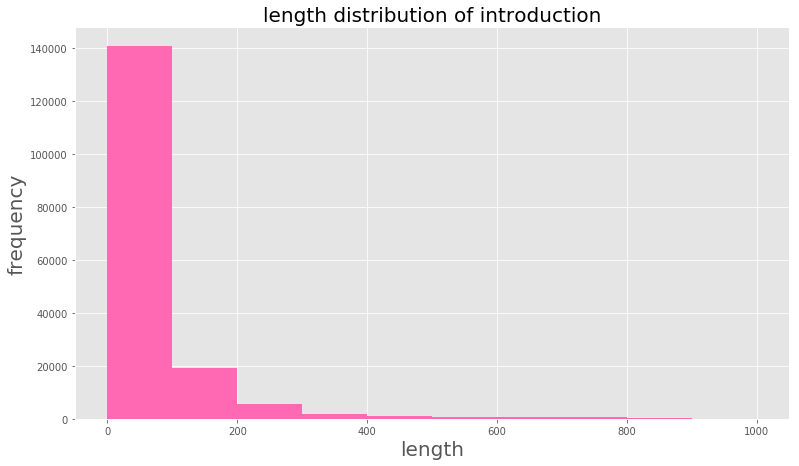

In [8]:
intro_lengths = [len(introduction) for introduction in text_train]#统计评论的长度

#绘制长度的直方图
fig,axe = plt.subplots(figsize=(12.8,7.2))
axe.hist(intro_lengths,bins=[0,100,200,300,400,500,600,700,800,900,1000],color="hotpink")
axe.set_title("length distribution of introduction",fontsize=20)
axe.set_xlabel("length",fontsize=20)
axe.set_ylabel("frequency",fontsize=20)
plt.show()

SENLEN = 400

# VOCAB_SIZE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in text_train for word in sequence]
word_counter_introduction = Counter(train_word_list)#统计每个词出现的次数
most_common_word_in_train_introduction = word_counter_introduction.most_common()#词频降序排序
VOCAB_SIZE = len(most_common_word_in_train_introduction) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_introduction)):
    if most_common_word_in_train_introduction[i][1] <= 1:
        VOCAB_SIZE = i + 1 #VOCAB_SIZE设为词频>=2的词的数量
        break
        
# 对训练集建表
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

# 将训练集的文本数字化
text_train = tokenizer.texts_to_sequences(text_train)
text_train = keras.preprocessing.sequence.pad_sequences(
    text_train, maxlen=SENLEN, padding='post')

# 将验证集的文本数字化
text_val = tokenizer.texts_to_sequences(text_val)
text_val = keras.preprocessing.sequence.pad_sequences(
    text_val, maxlen=SENLEN, padding='post')

# 将测试集的文本数字化
text_test = tokenizer.texts_to_sequences(text_test)
text_test = keras.preprocessing.sequence.pad_sequences(
    text_test, maxlen=SENLEN, padding='post')

## Bi-LSTM

In [21]:
'''
model : Bi-LSTM
'''
EMBED_SIZE = 128

# Bi-LSTM
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入，长度为SENLEN
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=True)(inp_text) #词嵌入层
x = keras.layers.Bidirectional(keras.layers.LSTM(EMBED_SIZE))(embed)# Bi-LSTM
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model2=keras.Model(inputs=inp_text,outputs=preds)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 128)          14050176  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

In [24]:
model2.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early2_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model2.fit(text_train, label_train,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early2_stopping],
    shuffle=True)
model2.save('model2.h5')

Train on 170700 samples, validate on 42676 samples
Epoch 1/50
170700/170700 [==============================] - 373s 2ms/step - loss: 0.2844 - acc: 0.9203 - val_loss: 0.1606 - val_acc: 0.9398
Epoch 2/50
170700/170700 [==============================] - 367s 2ms/step - loss: 0.1194 - acc: 0.9561 - val_loss: 0.1235 - val_acc: 0.9530
Epoch 3/50
170700/170700 [==============================] - 384s 2ms/step - loss: 0.0858 - acc: 0.9680 - val_loss: 0.1296 - val_acc: 0.9545
Epoch 4/50
170700/170700 [==============================] - 368s 2ms/step - loss: 0.0700 - acc: 0.9743 - val_loss: 0.1367 - val_acc: 0.9506
Epoch 5/50
170700/170700 [==============================] - 369s 2ms/step - loss: 0.0587 - acc: 0.9785 - val_loss: 0.1533 - val_acc: 0.9521
Epoch 6/50
170700/170700 [==============================] - 375s 2ms/step - loss: 0.0508 - acc: 0.9818 - val_loss: 0.1647 - val_acc: 0.9462
Epoch 7/50
170700/170700 [==============================] - 371s 2ms/step - loss: 0.0437 - acc: 0.9850 - val_

In [9]:
model2 = keras.models.load_model('model2.h5')

<Figure size 432x288 with 0 Axes>

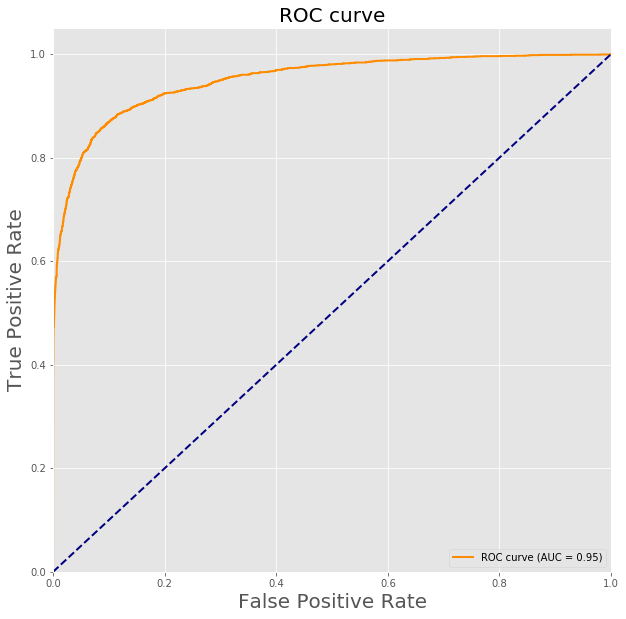

In [10]:
#对测试集做预测，并绘制ROC曲线
predict_test = model2.predict(text_test)
ROC(list(label_test.flatten()),predict_test.flatten())

In [12]:
y_true = list(label_test.flatten())
y_pre = predict_test.flatten()
fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1)
data_val_model2 = pd.DataFrame()
data_val_model2['true']=label_test
#data_val_model2['val'] = []
# 阈值的选择: fpr < 0.05
for i in range(len(fpr)):
    if fpr[i] >= 0.05:
        index = i - 1
        break
predict_threshold = threshold[index]
predict_val = predict_test
predict_class = np.zeros(len(text_test))
print('开始预测')
t0 = time.time()
for i in range(len(text_test)):
    if predict_val[i] > predict_threshold:
        data_val_model2.loc[i,'val'] = 1
    else:
        data_val_model2.loc[i,'val'] = 0
print("预测结束，耗时：%2s s"%(time.time()-t0))

开始预测
预测结束，耗时：5.921820878982544 s


In [13]:
TP = data_val_model2[(data_val_model2.true==1)&(data_val_model2.val==1)].shape[0]
TN = data_val_model2[(data_val_model2.true==0)&(data_val_model2.val==0)].shape[0]
FP = data_val_model2[(data_val_model2.true==0)&(data_val_model2.val==1)].shape[0]
FN = data_val_model2[(data_val_model2.true==1)&(data_val_model2.val==0)].shape[0]
print(TP,TN,FP,FN)
print("Accuracy: %3f"%((TP+TN)/(TP+TN+FP+FN)))
print("Precision: %3f"%(TP/(TP+FP)))
print("Recall: %3f"%((TP)/(TP+FN)))
print("Specificity: %3f"%((TN)/(TN+FP)))
print("Threshold: %3f"%predict_threshold)

2016 7266 382 509
Accuracy: 0.912415
Precision: 0.840701
Recall: 0.798416
Specificity: 0.950052
Threshold: 0.059658


## Text-CNN

In [42]:
'''
model: text-cnn
'''
EMBED_SIZE = 128

# text-cnn
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入，长度为SENLEN_TITLE
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=False)(inp_text)
cnn1 = keras.layers.Conv1D(128,1,padding='same', strides=1, activation='relu')(embed)
cnn1 = keras.layers.MaxPooling1D(pool_size=SENLEN)(cnn1)
cnn2 = keras.layers.Conv1D(128,2,padding='same', strides=1, activation='relu')(embed)
cnn2 = keras.layers.MaxPooling1D(pool_size=SENLEN)(cnn2)
cnn3 = keras.layers.Conv1D(128,3,padding='same', strides=1, activation='relu')(embed)
cnn3 = keras.layers.MaxPooling1D(pool_size=SENLEN)(cnn3)
x = keras.layers.concatenate([cnn1, cnn2, cnn3], axis=-1)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model3=keras.Model(inputs=inp_text,outputs=preds)
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 128)     14050176    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 128)     16512       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 400, 128)     32896       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [43]:
model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early2_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model3.fit(text_train, label_train,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early2_stopping],
    shuffle=True)
model3.save('model3.h5')

Train on 170700 samples, validate on 42676 samples
Epoch 1/50
170700/170700 [==============================] - 30s 175us/step - loss: 0.3093 - acc: 0.9087 - val_loss: 0.2518 - val_acc: 0.9116
Epoch 2/50
170700/170700 [==============================] - 26s 152us/step - loss: 0.1692 - acc: 0.9382 - val_loss: 0.1251 - val_acc: 0.9532
Epoch 3/50
170700/170700 [==============================] - 26s 151us/step - loss: 0.1043 - acc: 0.9597 - val_loss: 0.1148 - val_acc: 0.9553
Epoch 4/50
170700/170700 [==============================] - 26s 151us/step - loss: 0.0837 - acc: 0.9669 - val_loss: 0.1162 - val_acc: 0.9565
Epoch 5/50
170700/170700 [==============================] - 26s 152us/step - loss: 0.0661 - acc: 0.9747 - val_loss: 0.1224 - val_acc: 0.9557
Epoch 6/50
170700/170700 [==============================] - 26s 155us/step - loss: 0.0497 - acc: 0.9821 - val_loss: 0.1343 - val_acc: 0.9546
Epoch 7/50
170700/170700 [==============================] - 26s 154us/step - loss: 0.0353 - acc: 0.9883

<Figure size 432x288 with 0 Axes>

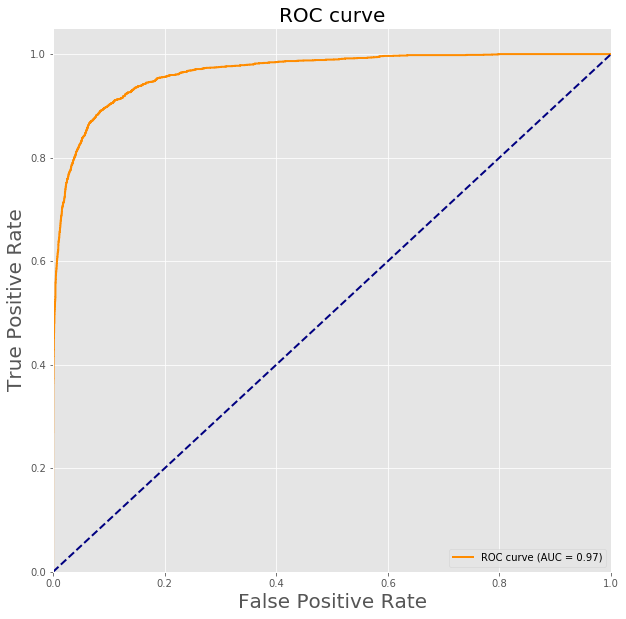

In [14]:
model3 = keras.models.load_model('model3.h5')
#对测试集做预测，并绘制ROC曲线
predict_test = model3.predict(text_test)
ROC(list(label_test.flatten()),predict_test.flatten())

In [15]:
y_true = list(label_test.flatten())
y_pre = predict_test.flatten()
fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1)
data_val_model3 = pd.DataFrame(columns={'val':[]})
data_val_model3['true']=label_test
# 阈值的选择: fpr < 0.05
for i in range(len(fpr)):
    if fpr[i] >= 0.05:
        index = i - 1
        break
predict_threshold = threshold[index]
predict_val = predict_test
predict_class = np.zeros(len(text_test))
print('开始预测')
t0 = time.time()
for i in range(len(text_test)):
    if predict_val[i] > predict_threshold:
        data_val_model3.loc[i,'val'] = 1
    else:
        data_val_model3.loc[i,'val'] = 0
print("预测结束，耗时：%2s s"%(time.time()-t0))

开始预测
预测结束，耗时：16.239074230194092 s


In [16]:
TP = data_val_model3[(data_val_model3.true==1)&(data_val_model3.val==1)].shape[0]
TN = data_val_model3[(data_val_model3.true==0)&(data_val_model3.val==0)].shape[0]
FP = data_val_model3[(data_val_model3.true==0)&(data_val_model3.val==1)].shape[0]
FN = data_val_model3[(data_val_model3.true==1)&(data_val_model3.val==0)].shape[0]
print(TP,TN,FP,FN)
print("Accuracy: %3f"%((TP+TN)/(TP+TN+FP+FN)))
print("Precision: %3f"%(TP/(TP+FP)))
print("Recall: %3f"%((TP)/(TP+FN)))
print("Specificity: %3f"%((TN)/(TN+FP)))
print("Threshold: %3f"%predict_threshold)

2094 7267 381 431
Accuracy: 0.920181
Precision: 0.846061
Recall: 0.829307
Specificity: 0.950183
Threshold: 0.027975


## SimpleRNN

In [49]:
'''
model : SimpleRNN
'''
EMBED_SIZE = 128

# Bi-LSTM
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入，长度为SENLEN
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=True)(inp_text) #词嵌入层
x = keras.layers.SimpleRNN(EMBED_SIZE)(embed)# Bi-LSTM
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model4=keras.Model(inputs=inp_text,outputs=preds)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 128)          14050176  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
__________

In [51]:
model4.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early2_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model4.fit(text_train, label_train,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early2_stopping],
    shuffle=True)
model4.save('model4.h5')

Train on 170700 samples, validate on 42676 samples
Epoch 1/50
170700/170700 [==============================] - 63s 370us/step - loss: 0.1280 - acc: 0.9539 - val_loss: 0.1371 - val_acc: 0.9469
Epoch 2/50
170700/170700 [==============================] - 61s 359us/step - loss: 0.1000 - acc: 0.9641 - val_loss: 0.1331 - val_acc: 0.9492
Epoch 3/50
170700/170700 [==============================] - 61s 357us/step - loss: 0.0826 - acc: 0.9698 - val_loss: 0.1449 - val_acc: 0.9484
Epoch 4/50
170700/170700 [==============================] - 62s 361us/step - loss: 0.0678 - acc: 0.9750 - val_loss: 0.1540 - val_acc: 0.9498
Epoch 5/50
170700/170700 [==============================] - 62s 362us/step - loss: 0.0557 - acc: 0.9799 - val_loss: 0.1801 - val_acc: 0.9505
Epoch 6/50
170700/170700 [==============================] - 63s 371us/step - loss: 0.0465 - acc: 0.9832 - val_loss: 0.2044 - val_acc: 0.9478
Epoch 7/50
170700/170700 [==============================] - 64s 372us/step - loss: 0.0369 - acc: 0.9872

<Figure size 432x288 with 0 Axes>

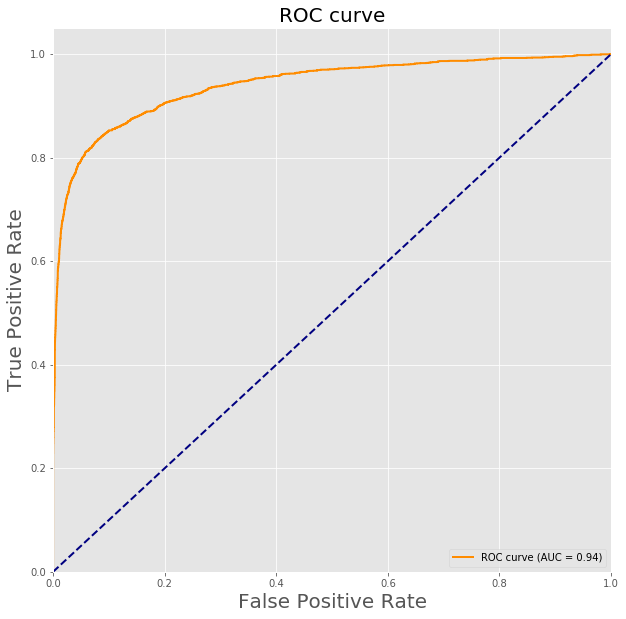

开始预测
预测结束，耗时：16.220953226089478 s
2008 7266 382 517
Accuracy: 0.911629
Precision: 0.840167
Recall: 0.795248
Specificity: 0.950052
Threshold: 0.018543


In [17]:
model4 = keras.models.load_model('model4.h5')
#对测试集做预测，并绘制ROC曲线
predict_test = model4.predict(text_test)
ROC(list(label_test.flatten()),predict_test.flatten())

y_true = list(label_test.flatten())
y_pre = predict_test.flatten()
fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1)
data_val_model4 = pd.DataFrame(columns={'val':[]})
data_val_model4['true']=label_test
# 阈值的选择: fpr < 0.05
for i in range(len(fpr)):
    if fpr[i] >= 0.05:
        index = i - 1
        break
predict_threshold = threshold[index]
predict_val = predict_test
predict_class = np.zeros(len(text_test))
print('开始预测')
t0 = time.time()
for i in range(len(text_test)):
    if predict_val[i] > predict_threshold:
        data_val_model4.loc[i,'val'] = 1
    else:
        data_val_model4.loc[i,'val'] = 0
print("预测结束，耗时：%2s s"%(time.time()-t0))

TP = data_val_model4[(data_val_model4.true==1)&(data_val_model4.val==1)].shape[0]
TN = data_val_model4[(data_val_model4.true==0)&(data_val_model4.val==0)].shape[0]
FP = data_val_model4[(data_val_model4.true==0)&(data_val_model4.val==1)].shape[0]
FN = data_val_model4[(data_val_model4.true==1)&(data_val_model4.val==0)].shape[0]
print(TP,TN,FP,FN)
print("Accuracy: %3f"%((TP+TN)/(TP+TN+FP+FN)))
print("Precision: %3f"%(TP/(TP+FP)))
print("Recall: %3f"%((TP)/(TP+FN)))
print("Specificity: %3f"%((TN)/(TN+FP)))
print("Threshold: %3f"%predict_threshold)

## Bi-LSTM+Attention

In [53]:
'''
model : Bi-LSTM+attention
'''
EMBED_SIZE = 128
# Bi-LSTM
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入，长度为SENLEN
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=True)(inp_text) #词嵌入层
x = keras.layers.Bidirectional(keras.layers.LSTM(EMBED_SIZE))(embed)# Bi-LSTM
attention_probs = keras.layers.Dense(EMBED_SIZE*2, activation='softmax', name='attention_vec')(x)
x = keras.layers.Multiply()([x, attention_probs])#attention层
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model5=keras.Model(inputs=inp_text,outputs=preds)
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 400, 128)     14050176    input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          263168      embedding_4[0][0]                
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 256)          65792       bidirectional_2[0][0]            
__________________________________________________________________________________________________
multiply_1

In [54]:
model5.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
#model2 = multi_gpu_model(model2, 2)  #GPU个数为2
early2_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='min') # 采用早停的策略
#tbCallBack = TensorBoard(log_dir="./model", histogram_freq=1,write_grads=True)
history = model5.fit(text_train, label_train,
    validation_data=[text_val,label_val],
    epochs=50,
    batch_size=512,
    callbacks=[early2_stopping],
    shuffle=True)
model5.save('model5.h5')

Train on 170700 samples, validate on 42676 samples
Epoch 1/50
170700/170700 [==============================] - 375s 2ms/step - loss: 0.4303 - acc: 0.9102 - val_loss: 0.2658 - val_acc: 0.9116
Epoch 2/50
170700/170700 [==============================] - 371s 2ms/step - loss: 0.2379 - acc: 0.9116 - val_loss: 0.2252 - val_acc: 0.9116
Epoch 3/50
170700/170700 [==============================] - 371s 2ms/step - loss: 0.2112 - acc: 0.9216 - val_loss: 0.2108 - val_acc: 0.9273
Epoch 4/50
170700/170700 [==============================] - 371s 2ms/step - loss: 0.1907 - acc: 0.9334 - val_loss: 0.1998 - val_acc: 0.9364
Epoch 5/50
170700/170700 [==============================] - 372s 2ms/step - loss: 0.1764 - acc: 0.9401 - val_loss: 0.1917 - val_acc: 0.9291
Epoch 6/50
170700/170700 [==============================] - 371s 2ms/step - loss: 0.1626 - acc: 0.9471 - val_loss: 0.1679 - val_acc: 0.9437
Epoch 7/50
170700/170700 [==============================] - 373s 2ms/step - loss: 0.1342 - acc: 0.9551 - val_

<Figure size 432x288 with 0 Axes>

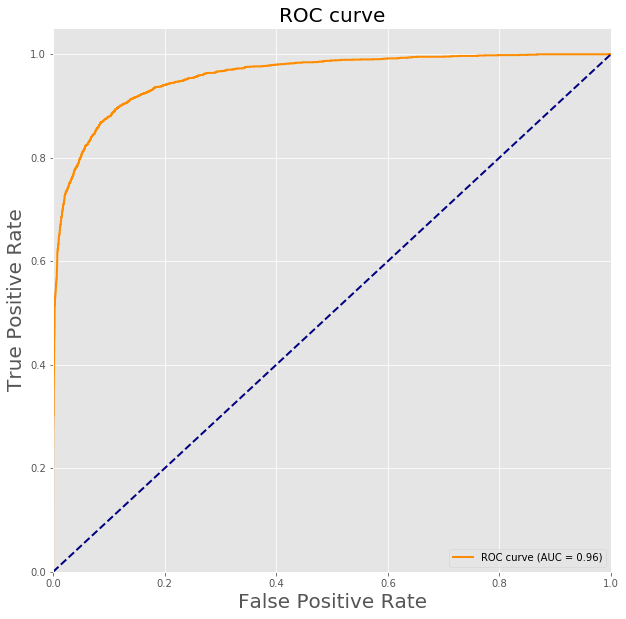

开始预测
预测结束，耗时：16.070427179336548 s
2022 7268 380 503
Accuracy: 0.913202
Precision: 0.841799
Recall: 0.800792
Specificity: 0.950314
Threshold: 0.167113


In [19]:
model5 = keras.models.load_model('model5.h5')
evaluate(model5,text_test,label_test)